In [1]:
using Distributions
using Random
using Statistics
using PoissonRandom
using ArgCheck
using QuadGK
using RunStatistics
using RunStatistics: t_obs

#include("MADMAX-runs.ipynb")


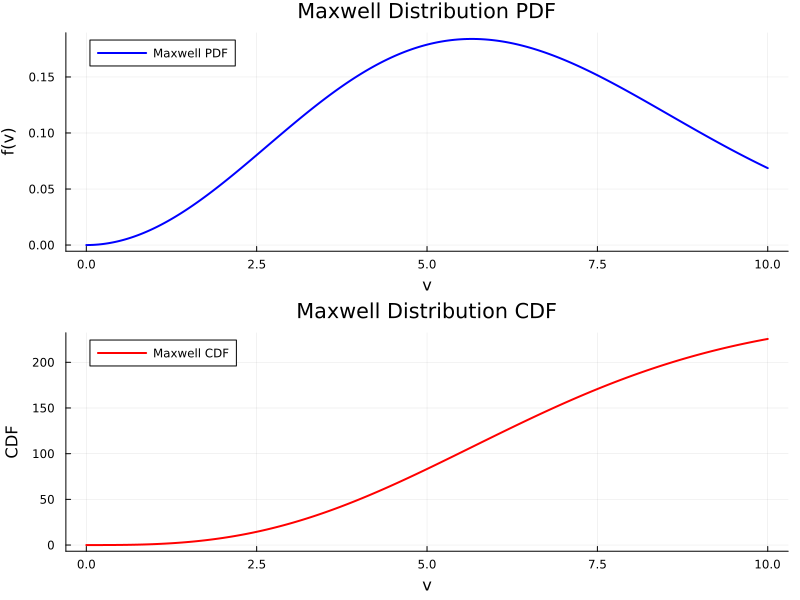

In [ ]:
using Plots, QuadGK

# Maxwell PDF (manually defined)
function maxwell_pdf(v, w)
    v < 0 && return 0.0
    return  (v^2 / w^3) * exp(-v^2 / (2 * w^2))
end

# Normalize for plotting
function maxwell_cdf(v, w)
    v < 0 && return 0.0
    integral, _ = quadgk(x -> A*maxwell_pdf(x, w), 0, v)
    return integral
end

# Parameters
A=20
w = 4.0
x = range(0, stop=10.0, length=1000)

# Compute values
pdf_vals = [maxwell_pdf(xi, w) for xi in x]
cdf_vals = [maxwell_cdf(xi, w) for xi in x]

# Plot PDF and CDF
p1 = plot(x, pdf_vals, lw=2, label="Maxwell PDF", color=:blue)
xlabel!("v"); ylabel!("f(v)"); title!("Maxwell Distribution PDF")

p2 = plot(x, cdf_vals, lw=2, label="Maxwell CDF", color=:red)
xlabel!("v"); ylabel!("CDF"); title!("Maxwell Distribution CDF")

plot(p1, p2, layout=(2, 1), size=(800, 600))


# Maxwell Boltzmann

In [2]:
#
# Same as before, but we now use a Lorentzian instead of a Gaussian for the signal shape
#

# Run multiple tests
n_tests = 1000
nbins = 10000

# Squares Statistic settings
Ns1 = zeros(2); Ns1[1] = 50; Ns1[2] = Int(nbins / Ns1[1])
Ns2 = zeros(2); Ns2[1] = 50; Ns2[2] = Int(nbins / 2 / Ns2[1])
Ns5 = zeros(2); Ns5[1] = 50; Ns5[2] = Int(nbins / 5 / Ns5[1])
Ns10 = zeros(2); Ns10[1] = 50; Ns10[2] = Int(nbins / 10 / Ns10[1])

epsp = 1e-7

N_amplitude = 8
amplitude = zeros(N_amplitude)
N_width = 6
width = zeros(N_width)

pv1 = zeros(Real, (N_amplitude, N_width, n_tests))
pv2 = zeros(Real, (N_amplitude, N_width, n_tests))
pv5 = zeros(Real, (N_amplitude, N_width, n_tests))
pv10 = zeros(Real, (N_amplitude, N_width, n_tests))

using QuadGK

# Define Maxwell PDF (unnormalized)
function maxwell_pdf(v, w)
    v < 0 && return 0.0
    return (v^2 / w^3) * exp(-v^2 / (2 * w^2))
end

# Main signal_integral function with accurate integration for Maxwell
function signal_integral(x1, x2, A, w, signal_type::Symbol)
    if signal_type == :gaussian
        ds = Normal(0.0, w)
        return A * (cdf(ds, x2) - cdf(ds, x1))

    elseif signal_type == :lorentzian
        return A * (1 / π) * (atan(x2 / (0.5 * w)) - atan(x1 / (0.5 * w)))

    elseif signal_type == :maxwell
        # Numerically integrate the Maxwell-like shape between x1 and x2
        val, _ = quadgk(v -> maxwell_pdf(v, w), max(0.0, x1), max(0.0, x2))
        return A * val

    else
        error("Unknown signal type: $signal_type")
    end
end


function maxwell_pdf(v, w)
    v < 0 && return 0.0
    return  (v^2 / w^3) * exp(-v^2 / (2 * w^2))
end

# Normalize for plotting
function maxwell_cdf(v, w)
    v < 0 && return 0.0
    integral, _ = quadgk(x -> A*maxwell_pdf(x, w), 0, v)
    return integral
end

for i = 1:N_amplitude
    amplitude[i] = (i - 1) * 4

    for j = 1:N_width
        width[j] = 2 * j  # this is FWHM of Lorentzian

        for n = 1:n_tests
            Run1 = zeros(nbins)

            for bin = 1:nbins
                x1 = (bin - 1) - nbins / 2
                x2 = bin - nbins / 2
                bin_integral = signal_integral(x1, x2, amplitude[i], width[i], :gaussian)
                d = Normal(bin_integral, 1.0)
                Run1[bin] = rand(d)
            end

            Squares = t_obs(Run1, 0.0, 1.0)
            pv1[i, j, n] = squares_pvalue_approx(Squares[1], Ns1, epsp)

            step = 2
            nbins2 = Int(nbins / step)
            Run2 = zeros(nbins2)
            newbin = 1; l = 1
            while l <= nbins - step
                Run2[newbin] = sum(Run1[l : l + step - 1])
                newbin += 1; l += step
            end
            Squares = t_obs(Run2, 0.0, step)
            pv2[i, j, n] = squares_pvalue_approx(Squares[1], Ns2, epsp)

            step = 5
            nbins5 = Int(nbins / step)
            Run5 = zeros(nbins5)
            newbin = 1; l = 1
            while l <= nbins - step
                Run5[newbin] = sum(Run1[l : l + step - 1])
                newbin += 1; l += step
            end
            Squares = t_obs(Run5, 0.0, step)
            pv5[i, j, n] = squares_pvalue_approx(Squares[1], Ns5, epsp)

            step = 10
            nbins10 = Int(nbins / step)
            Run10 = zeros(nbins10)
            newbin = 1; l = 1
            while l <= nbins - step
                Run10[newbin] = sum(Run1[l : l + step - 1])
                newbin += 1; l += step
            end
            Squares = t_obs(Run10, 0.0, step)
            pv10[i, j, n] = squares_pvalue_approx(Squares[1], Ns10, epsp)
        end

        println(" A=", amplitude[i], " width=", round(width[j], digits=3),
                "  1 ", round(mean(pv1[i,j,:]), digits=3), " ", round(std(pv1[i,j,:]), digits=3))
        println(" A=", amplitude[i], " width=", round(width[j], digits=3),
                "  2 ", round(mean(pv2[i,j,:]), digits=3), " ", round(std(pv2[i,j,:]), digits=3))
        println(" A=", amplitude[i], " width=", round(width[j], digits=3),
                "  5 ", round(mean(pv5[i,j,:]), digits=3), " ", round(std(pv5[i,j,:]), digits=3))
        println(" A=", amplitude[i], " width=", round(width[j], digits=3),
                " 10 ", round(mean(pv10[i,j,:]), digits=3), " ", round(std(pv10[i,j,:]), digits=3))
    end
end


 A=0.0 width=2.0  1 0.49 0.281
 A=0.0 width=2.0  2 0.494 0.294
 A=0.0 width=2.0  5 0.489 0.294
 A=0.0 width=2.0 10 0.491 0.297
 A=0.0 width=4.0  1 0.493 0.291
 A=0.0 width=4.0  2 0.497 0.29
 A=0.0 width=4.0  5 0.499 0.294
 A=0.0 width=4.0 10 0.498 0.289
 A=0.0 width=6.0  1 0.502 0.282
 A=0.0 width=6.0  2 0.504 0.294
 A=0.0 width=6.0  5 0.492 0.29
 A=0.0 width=6.0 10 0.492 0.284
 A=0.0 width=8.0  1 0.506 0.286
 A=0.0 width=8.0  2 0.507 0.288
 A=0.0 width=8.0  5 0.492 0.288
 A=0.0 width=8.0 10 0.496 0.281
 A=0.0 width=10.0  1 0.493 0.298
 A=0.0 width=10.0  2 0.507 0.285
 A=0.0 width=10.0  5 0.508 0.287
 A=0.0 width=10.0 10 0.51 0.288
 A=0.0 width=12.0  1 0.49 0.287
 A=0.0 width=12.0  2 0.487 0.291
 A=0.0 width=12.0  5 0.497 0.283
 A=0.0 width=12.0 10 0.503 0.293
 A=4.0 width=2.0  1 0.507 0.288
 A=4.0 width=2.0  2 0.504 0.293
 A=4.0 width=2.0  5 0.498 0.291
 A=4.0 width=2.0 10 0.496 0.289
 A=4.0 width=4.0  1 0.5 0.289
 A=4.0 width=4.0  2 0.489 0.286
 A=4.0 width=4.0  5 0.506 0.291
 A=4.0 

LoadError: BoundsError: attempt to access 6-element Vector{Float64} at index [7]

In [4]:
using Printf
using LaTeXStrings

#
# Print latex table code
#

open("Meanp_MB.txt","w") do io
println(io,"\\begin{table}")
println(io,"\\centering")
println(io,"\\begin{tabular}{cccccccc}")
println(io,"\\hline")
println(io," A & BinSize & \$\\sigma_{\\rm sig}\$ & \$\\sigma_{\\rm sig}\$ & \$\\sigma_{\\rm sig}\$ & \$\\sigma_{\\rm sig}\$ & \$\\sigma_{\\rm sig}\$ & \$\\sigma_{\\rm sig}\$ \\\\")
println(io," & "," & ",width[1]," & ",width[2]," & ",width[3]," & ",width[4]," & ",width[5]," & ",width[6],"\\\\")
println(io,"\\hline")
for n=1:N_amplitude
    println(io,Int(amplitude[n])," & ",1," & ",round(mean(pv1[n,1,:]), sigdigits=2)," & ",round(mean(pv1[n,2,:]), sigdigits=2)," & ",
            round(mean(pv1[n,3,:]), sigdigits=2)," & ",round(mean(pv1[n,4,:]), sigdigits=2)," & ",
            round(mean(pv1[n,5,:]), sigdigits=2)," & ",round(mean(pv1[n,6,:]), sigdigits=2),"\\\\")
    println(io,Int(amplitude[n])," & ",2," & ",round(mean(pv2[n,1,:]), sigdigits=2)," & ",round(mean(pv2[n,2,:]), sigdigits=2)," & ",
            round(mean(pv2[n,3,:]), sigdigits=2)," & ",round(mean(pv2[n,4,:]), sigdigits=2)," & ",
            round(mean(pv2[n,5,:]), sigdigits=2)," & ",round(mean(pv2[n,6,:]), sigdigits=2),"\\\\")
    println(io,Int(amplitude[n])," & ",5," & ",round(mean(pv5[n,1,:]), sigdigits=2)," & ",round(mean(pv5[n,2,:]), sigdigits=2)," & ",
            round(mean(pv5[n,3,:]), sigdigits=2)," & ",round(mean(pv5[n,4,:]), sigdigits=2)," & ",
            round(mean(pv5[n,5,:]), sigdigits=2)," & ",round(mean(pv5[n,6,:]), sigdigits=2),"\\\\")
    println(io,Int(amplitude[n])," & ",10," & ",round(mean(pv10[n,1,:]), sigdigits=2)," & ",round(mean(pv10[n,2,:]), sigdigits=2)," & ",
            round(mean(pv10[n,3,:]), sigdigits=2)," & ",round(mean(pv10[n,4,:]), sigdigits=2)," & ",
            round(mean(pv10[n,5,:]), sigdigits=2)," & ",round(mean(pv10[n,6,:]), sigdigits=2),"\\\\")
    println(io,"\\hline")
end
println(io,"\\hline")
println(io,"\\end{tabular}")
println(io,"\\caption{Mean of \$p\$-values. The first column gives the amplitude,\$A\$, of the input signal.  
        The second column give the width of the bins in which power is measured, and the succeeding columns
        give the width of the input signal \$\\sigma_{\\rm sig}\$ . }")
println(io,"\\label{tab:Meanp}")
println(io,"\\end{table}")
end





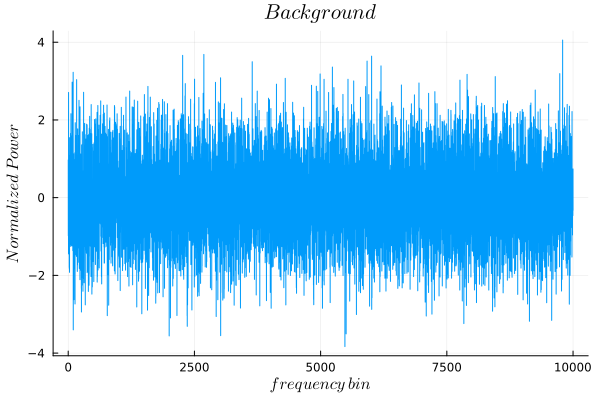

In [5]:
pcut=0.05
pass1=zeros(N_amplitude,N_width)
pass2=zeros(N_amplitude,N_width)
pass5=zeros(N_amplitude,N_width)
pass10=zeros(N_amplitude,N_width)

for n=1:N_amplitude
    amplitude[n]=Int(amplitude[n])
end

for i=1:N_amplitude
    for j=1:N_width
        for k=1:n_tests
            if (pv1[i,j,k]<pcut) pass1[i,j]+=1/n_tests            end
            if (pv2[i,j,k]<pcut) pass2[i,j]+=1/n_tests            end
            if (pv5[i,j,k]<pcut) pass5[i,j]+=1/n_tests            end
            if (pv10[i,j,k]<pcut) pass10[i,j]+=1/n_tests            end
        end
    end
end
#
# Print out results - different tables for different bin groupings
#
# Bin size=1

open("Passpcut_MB.txt","w") do io
println(io,"\\begin{table}")
println(io,"\\centering")
println(io,"\\begin{tabular}{cccccccc}")
println(io,"\\hline")
println(io," A & BinSize & \$\\sigma_{\\rm sig}\$ & \$\\sigma_{\\rm sig}\$ & \$\\sigma_{\\rm sig}\$ & \$\\sigma_{\\rm sig}\$ & \$\\sigma_{\\rm sig}\$ & \$\\sigma_{\\rm sig}\$ \\\\")
println(io," & "," & ",width[1]," & ",width[2]," & ",width[3]," & ",width[4]," & ",width[5]," & ",width[6],"\\\\")
println(io,"\\hline")
for n=1:N_amplitude
    println(io,Int(amplitude[n])," & ",1," & ",round(pass1[n,1], sigdigits=2)," & ",round(pass1[n,2], sigdigits=2)," & ",
            round(pass1[n,3], sigdigits=2)," & ",round(pass1[n,4], sigdigits=2)," & ",
            round(pass1[n,5], sigdigits=2)," & ",round(pass1[n,6], sigdigits=2),"\\\\")
    println(io,Int(amplitude[n])," & ",2," & ",round(pass2[n,1], sigdigits=2)," & ",round(pass2[n,2], sigdigits=2)," & ",
            round(pass2[n,3], sigdigits=2)," & ",round(pass2[n,4], sigdigits=2)," & ",
            round(pass2[n,5], sigdigits=2)," & ",round(pass2[n,6], sigdigits=2),"\\\\")    
    println(io,Int(amplitude[n])," & ",5," & ",round(pass5[n,1], sigdigits=2)," & ",round(pass5[n,2], sigdigits=2)," & ",
            round(pass5[n,3], sigdigits=2)," & ",round(pass5[n,4], sigdigits=2)," & ",
            round(pass5[n,5], sigdigits=2)," & ",round(pass5[n,6], sigdigits=2),"\\\\")    
    println(io,Int(amplitude[n])," & ",10," & ",round(pass10[n,1], sigdigits=2)," & ",round(pass10[n,2], sigdigits=2)," & ",
            round(pass10[n,3], sigdigits=2)," & ",round(pass10[n,4], sigdigits=2)," & ",
            round(pass10[n,5], sigdigits=2)," & ",round(pass10[n,6], sigdigits=2),"\\\\")
    println(io,"\\hline")
end
println(io,"\\hline")
println(io,"\\end{tabular}")
println(io,"\\caption{The fraction of trials passing the \$p\\leq 0.05\$ cut. The first column gives the amplitude,\$A\$, of the input signal.  
        The second column give the width of the bins in which power is measured, and the succeeding columns
        give the width of the input signal \$\\sigma_{\\rm sig}\$ . }")
println(io,"\\label{tab:Pass}")
println(io,"\\end{table}")
end

using Plots
#
# Make some useful plots
#
using LaTeXStrings
Random.seed!(1234);
Run=randn(nbins)

p1=plot(Run,lw=1,legend=:none,xlabel=L"frequency \; bin", ylabel=L"Normalized \; Power",title=L"Background")


In [ ]:
Squares=t_obs(Run, 0., 1.)
println(Squares)
pv = squares_pvalue_approx(Squares[1],Ns1, epsp)
plot(9751:9800,Run[9751:9800],lw=1,seriestype=:bar,legend=:none,xlabel=L"frequency \; bin", ylabel=L"Normalized \; Power",ylims=(-4.,4.))
p2=plot!(9789:9794,Run[9789:9794],lw=1,seriestype=:bar,legend=:none,color="red")
plot(p1,p2,layout=(2,1))

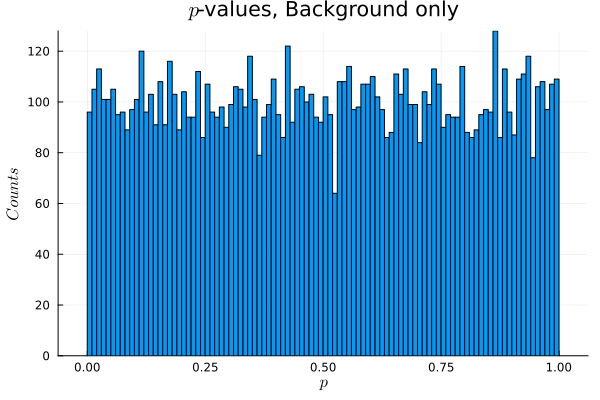

In [33]:
# 
# As a sanity check, we see if the p-value distribution is flat for background only
#
Random.seed!(1234);

nsanity=10000
pv=zeros(nsanity)
for i=1:nsanity
    Run=randn(nbins)
    Squares=t_obs(Run, 0., 1.)
    pv[i] = squares_pvalue_approx(Squares[1],Ns1, epsp)
end
p1=histogram(pv,bins=100,legend=:none,xlabel=L"$p$", ylabel=L"Counts",title=L"$p$-values, Background only")

In [34]:
pv , Squares

([0.11603050397138204, 0.586455788048177, 0.4002702162423437, 0.8281234968121648, 0.7991282857278892, 0.8731459114204969, 0.8308925135786969, 0.3906011941960873, 0.013567149380289578, 0.42159773972135883  …  0.15881968610306463, 0.45318233622650206, 0.9724020814622492, 0.4323990717962404, 0.24684119491882428, 0.039964740842229896, 0.3368905916430075, 0.3326618455648118, 0.049994450501855026, 0.42125672410364157], (21.394475760835988, [6428, 6429, 6430, 6431, 6432, 6433, 6434]))

(21.394475760835988, [6428, 6429, 6430, 6431, 6432, 6433, 6434])


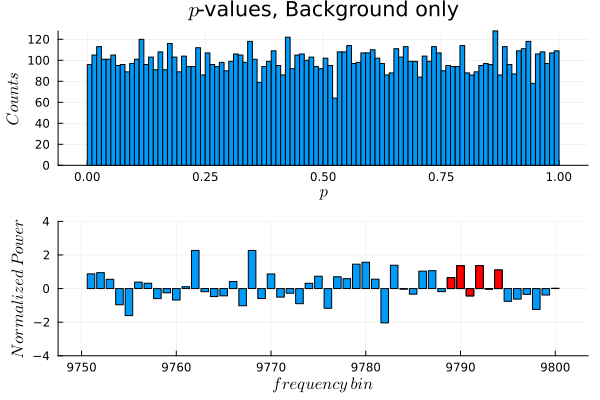

In [ ]:
# Now add a substantial signal and see the distorted p-value distribution

Run1=zeros(nbins)
A=20
w=4
ds = Normal(0.,w)
pvs=zeros(nsanity)

for i=1:nsanity
    for bin=1:nbins
        x1=(bin-1) - nbins/2
        x2=bin - nbins/2
        
        bin_integral=signal_integral(x1, x2, A, w, :gaussian)
#
        d = Normal(bin_integral,1.)
        Run1[bin]=rand(d)
    end       
    Squares=t_obs(Run1, 0., 1.)
    pvs[i] = squares_pvalue_approx(Squares[1],Ns1, epsp)
end

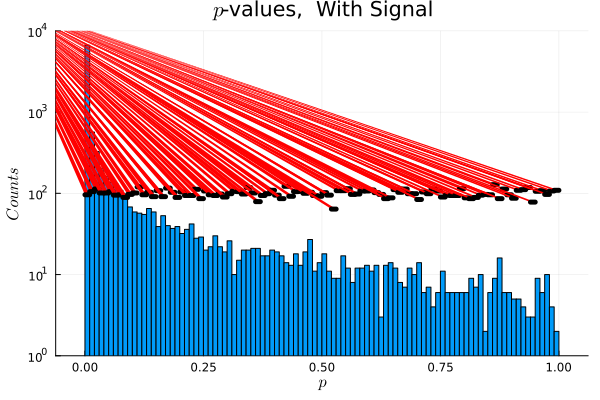

In [37]:
using Plots
p3=histogram(pvs,bins=100,yaxis=:log10,ylims=(1,10000),legend=:none,xlabel=L"$p$", ylabel=L"Counts",title=L"$p$-values,  With Signal")
p3=histogram!([pv],bins=100,color="red",xlabel=L"$p$", ylabel=L"Counts",lw=5)

In [40]:
import Pkg
Pkg.add("DSP")

   Resolving package versions...
  No Changes to `C:\Users\Lenovo\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\Lenovo\.julia\environments\v1.11\Manifest.toml`


In [69]:
using Distributions, Statistics, Plots, LaTeXStrings
using LinearAlgebra  # For matrix operations in SG filter

# Assuming these functions exist from your original code
# t_obs(data, mean, std) - computes Squares statistic
# squares_pvalue_approx(squares, Ns, eps) - computes p-value
# signal_integral(x1, x2, A, w, signal_type) - computes signal integral

#
# Savitzky-Golay Filter Analysis for Statistical Testing
# Comparing p-value distributions with and without SG smoothing
#

# Savitzky-Golay filter implementation
function savgol_coeffs(window_length, poly_order)
    """
    Compute the coefficients for a Savitzky-Golay filter.
    """
    if window_length % 2 == 0
        error("Window length must be odd")
    end
    
    half_window = div(window_length - 1, 2)
    
    # Create the design matrix
    A = zeros(window_length, poly_order + 1)
    for i in 1:window_length
        x = i - half_window - 1  # Center around 0
        for j in 1:(poly_order + 1)
            A[i, j] = x^(j-1)
        end
    end
    
    # Solve for coefficients (least squares solution)
    # We want the coefficients for the 0th derivative (smoothing)
    pinv_A = pinv(A)
    coeffs = pinv_A[1, :]  # First row corresponds to 0th derivative
    
    return coeffs
end

function apply_savgol_filter(data, window_length, poly_order)
    """
    Apply Savitzky-Golay filter to data.
    """
    if window_length >= length(data)
        return copy(data)  # Can't filter if window is too large
    end
    
    coeffs = savgol_coeffs(window_length, poly_order)
    half_window = div(window_length - 1, 2)
    
    filtered_data = zeros(length(data))
    
    for i in 1:length(data)
        # Determine the window boundaries
        start_idx = max(1, i - half_window)
        end_idx = min(length(data), i + half_window)
        
        # Handle edge cases by adjusting coefficients
        if i <= half_window || i > length(data) - half_window
            # For edge points, use simple moving average or copy original
            window_data = data[start_idx:end_idx]
            filtered_data[i] = mean(window_data)
        else
            # Apply full SG filter
            filtered_data[i] = sum(coeffs .* data[start_idx:end_idx])
        end
    end
    
    return filtered_data
end

# Parameters matching original analysis
n_tests = 1000
nbins = 10000

# Squares Statistic settings (same as original)
Ns1 = zeros(2); Ns1[1] = 50; Ns1[2] = Int(nbins / Ns1[1])
epsp = 1e-7

# SG Filter parameters to test
sg_window_lengths = [5]  # Must be odd
sg_poly_order = 3

# Signal parameters for testing
test_amplitudes = [0,10,15,20]  # Background-only, weak signal, strong signal  
test_width = 2.0

# Storage for results
results = Dict()

# Helper function to apply SG filter
function apply_sg_filter(data, window_length, poly_order)
    return apply_savgol_filter(data, window_length, poly_order)
end

# Define signal_integral function (simplified version)
function signal_integral(x1, x2, A, w, signal_type::Symbol)
    if signal_type == :gaussian
        ds = Normal(0.0, w)
        return A * (cdf(ds, x2) - cdf(ds, x1))
    else
        error("Only Gaussian implemented for this analysis")
    end
end

println("Starting Savitzky-Golay Filter Analysis...")
println("=" ^50)
Random.seed!(1234);


# Loop through different scenarios
for (amp_idx, amplitude) in enumerate(test_amplitudes)
    scenario_name = amplitude == 0 ? "Background-only" : "Signal+Background (A=$amplitude)"
    println("\nAnalyzing: $scenario_name")
    println("-" ^30)
    
    # Storage for this amplitude
    results[amplitude] = Dict()
    
    # Test original (unfiltered) data first
    pv_original = zeros(n_tests)
    
    for test = 1:n_tests
        # Generate data
        Run = zeros(nbins)
        
        if amplitude == 0
            # Background only
            Run = randn(nbins)
        else
            # Signal + Background
            for bin = 1:nbins
                x1 = (bin - 1) - nbins / 2
                x2 = bin - nbins / 2
                bin_integral = signal_integral(x1, x2, amplitude, test_width, :gaussian)
                d = Normal(bin_integral, 1.0)
                Run[bin] = rand(d)
            end
        end
        
        # Calculate p-value for original data
        Squares = t_obs(Run, 0.0, 1.0)
        pv_original[test] = squares_pvalue_approx(Squares[1], Ns1, epsp)
    end
    
    results[amplitude]["original"] = pv_original
    println("Original - Mean p-value: $(round(mean(pv_original), digits=3)), Std: $(round(std(pv_original), digits=3))")
    
    # Test different SG filter window lengths
    for window_length in sg_window_lengths
        pv_filtered = zeros(n_tests)
        
        for test = 1:n_tests
            # Generate data (same as above)
            Run = zeros(nbins)
            
            if amplitude == 0
                Run = randn(nbins)
            else
                for bin = 1:nbins
                    x1 = (bin - 1) - nbins / 2
                    x2 = bin - nbins / 2
                    bin_integral = signal_integral(x1, x2, amplitude, test_width, :gaussian)
                    d = Normal(bin_integral, 1.0)
                    Run[bin] = rand(d)
                end
            end
            
            # Apply SG filter
            Run_filtered = apply_sg_filter(Run, window_length, sg_poly_order)
            
            # Calculate p-value for filtered data
            Squares = t_obs(Run_filtered, 0.0, 1.0)
            pv_filtered[test] = squares_pvalue_approx(Squares[1], Ns1, epsp)
        end
        
        results[amplitude]["sg_$window_length"] = pv_filtered
        println("SG($window_length) - Mean p-value: $(round(mean(pv_filtered), digits=3)), Std: $(round(std(pv_filtered), digits=3))")
    end
end

println("\n" * "=" ^50)


Starting Savitzky-Golay Filter Analysis...

Analyzing: Background-only
------------------------------
Original - Mean p-value: 0.494, Std: 0.28
SG(5) - Mean p-value: 0.764, Std: 0.27

Analyzing: Signal+Background (A=10)
------------------------------
Original - Mean p-value: 0.294, Std: 0.286
SG(5) - Mean p-value: 0.514, Std: 0.365

Analyzing: Signal+Background (A=15)
------------------------------
Original - Mean p-value: 0.036, Std: 0.11
SG(5) - Mean p-value: 0.075, Std: 0.184

Analyzing: Signal+Background (A=20)
------------------------------
Original - Mean p-value: 0.0, Std: 0.003
SG(5) - Mean p-value: 0.001, Std: 0.016



Creating Plots...


3-element Vector{Any}:
 Plot{Plots.GRBackend() n=5}
 Plot{Plots.GRBackend() n=5}
 Plot{Plots.GRBackend() n=5}

Creating Plots...


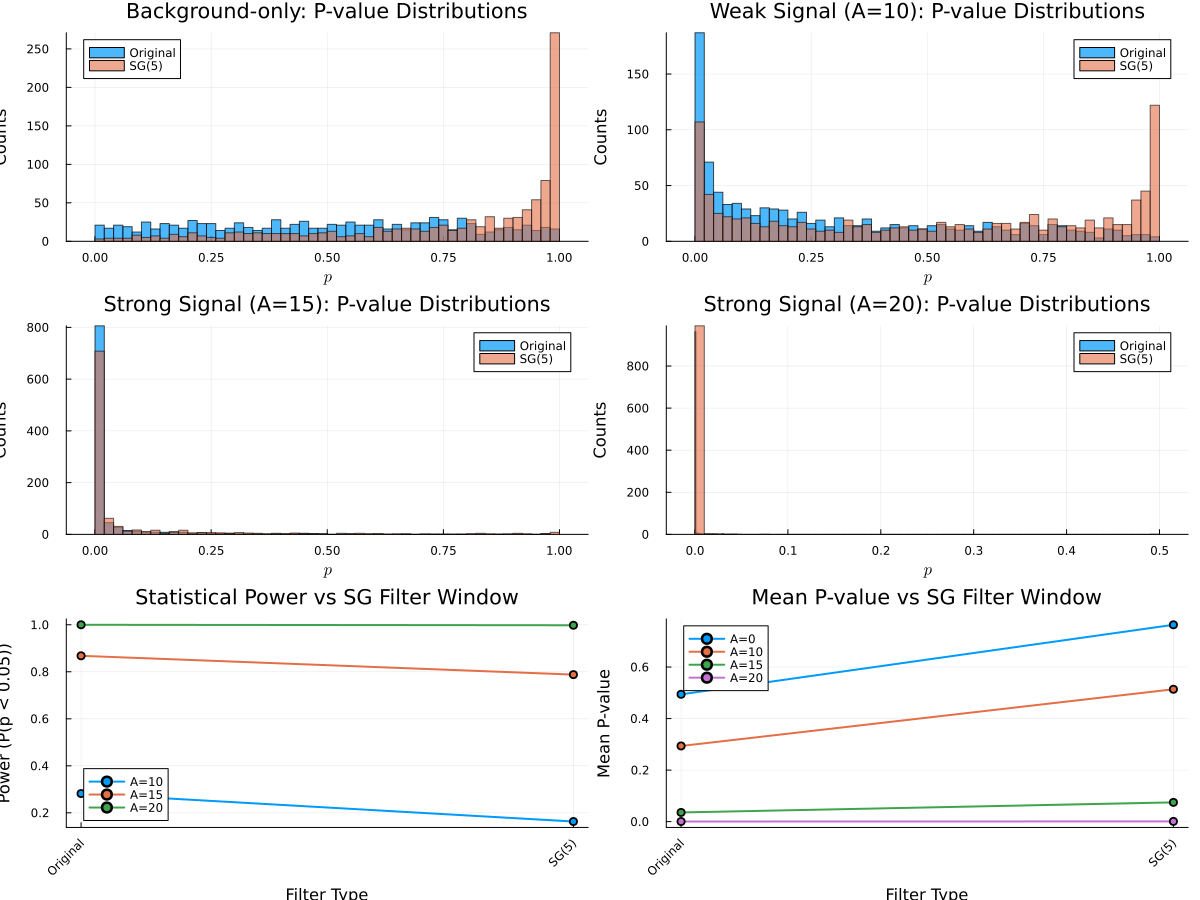


SUMMARY STATISTICS

Background-only:
Method		Mean p-value	Std p-value	Power
--------------------------------------------------
Original	0.494		0.28		0.049
SG(5)		0.764		0.27		0.009

Signal+Background (A=10):
Method		Mean p-value	Std p-value	Power
--------------------------------------------------
Original	0.294		0.286		0.282
SG(5)		0.514		0.365		0.163

Signal+Background (A=15):
Method		Mean p-value	Std p-value	Power
--------------------------------------------------
Original	0.036		0.11		0.868
SG(5)		0.075		0.184		0.788

Signal+Background (A=20):
Method		Mean p-value	Std p-value	Power
--------------------------------------------------
Original	0.0		0.003		1.0
SG(5)		0.001		0.016		0.998

Analysis completed!


In [70]:
println("Creating Plots...")

# Create comprehensive plots
plots_array = []

# 1. P-value distributions for background-only
p1 = histogram(results[0]["original"], bins=50, alpha=0.7, label="Original", 
               title="Background-only: P-value Distributions", 
               xlabel=L"p", ylabel="Counts")

for window_length in sg_window_lengths
    histogram!(p1, results[0]["sg_$window_length"], bins=50, alpha=0.6, 
               label="SG($window_length)")
end

push!(plots_array, p1)

# 2. P-value distributions for weak signal (log scale for better visibility)
if 10 in test_amplitudes
    p2 = histogram(results[10]["original"], bins=50, alpha=0.7, label="Original",
                   title="Weak Signal (A=10): P-value Distributions",
                   xlabel=L"p", ylabel="Counts")
    
    for window_length in sg_window_lengths
        histogram!(p2, results[10]["sg_$window_length"], bins=50, alpha=0.6,
                   label="SG($window_length)")
    end
    
    push!(plots_array, p2)
end

# 3. P-value distributions for strong signal
if 15 in test_amplitudes
    p3 = histogram(results[15]["original"], bins=50, alpha=0.7, label="Original",
                   title="Strong Signal (A=15): P-value Distributions", 
                   xlabel=L"p", ylabel="Counts")
    
    for window_length in sg_window_lengths
        histogram!(p3, results[15]["sg_$window_length"], bins=50, alpha=0.6,
                   label="SG($window_length)")
    end
    
    push!(plots_array, p3)
end
if 20 in test_amplitudes
    p3 = histogram(results[20]["original"], bins=50, alpha=0.7, label="Original",
                   title="Strong Signal (A=20): P-value Distributions", 
                   xlabel=L"p", ylabel="Counts")
    
    for window_length in sg_window_lengths
        histogram!(p3, results[20]["sg_$window_length"], bins=50, alpha=0.6,
                   label="SG($window_length)")
    end
    
    push!(plots_array, p3)
end

# 4. Statistical Power Comparison (fraction of p-values < 0.05)
labels = ["Original"]
append!(labels, ["SG($w)" for w in sg_window_lengths])

signal_amplitudes = [a for a in test_amplitudes if a > 0]
if !isempty(signal_amplitudes)
    # Create matrix for power data
    power_matrix = zeros(length(labels), length(signal_amplitudes))
    
    for (amp_idx, amplitude) in enumerate(signal_amplitudes)
        # Original
        power_matrix[1, amp_idx] = mean(results[amplitude]["original"] .< 0.05)
        
        # SG filtered
        for (sg_idx, window_length) in enumerate(sg_window_lengths)
            power_matrix[sg_idx + 1, amp_idx] = mean(results[amplitude]["sg_$window_length"] .< 0.05)
        end
    end
    
    p4 = plot(1:length(labels), power_matrix, marker=:circle, linewidth=2,
              title="Statistical Power vs SG Filter Window",
              xlabel="Filter Type", ylabel="Power (P(p < 0.05))",
              label=reshape(["A=$a" for a in signal_amplitudes], 1, :),
              xticks=(1:length(labels), labels), xrotation=45)
    
    push!(plots_array, p4)
end

# 5. Mean p-value comparison
# Create matrix for mean p-value data
mean_matrix = zeros(length(labels), length(test_amplitudes))

for (amp_idx, amplitude) in enumerate(test_amplitudes)
    # Original
    mean_matrix[1, amp_idx] = mean(results[amplitude]["original"])
    
    # SG filtered
    for (sg_idx, window_length) in enumerate(sg_window_lengths)
        mean_matrix[sg_idx + 1, amp_idx] = mean(results[amplitude]["sg_$window_length"])
    end
end

p5 = plot(1:length(labels), mean_matrix, marker=:circle, linewidth=2,
          title="Mean P-value vs SG Filter Window",
          xlabel="Filter Type", ylabel="Mean P-value",
          label=reshape(["A=$a" for a in test_amplitudes], 1, :),
          xticks=(1:length(labels), labels), xrotation=45)

push!(plots_array, p5)

# Display all plots
final_plot = plot(plots_array..., layout=(3,2), size=(1200, 900))
display(final_plot)

# Summary statistics
println("\n" * "=" ^50)
println("SUMMARY STATISTICS")
println("=" ^50)

for amplitude in test_amplitudes
    scenario = amplitude == 0 ? "Background-only" : "Signal+Background (A=$amplitude)"
    println("\n$scenario:")
    println("Method\t\tMean p-value\tStd p-value\tPower")
    println("-" ^50)
    
    # Original
    mean_p = mean(results[amplitude]["original"])
    std_p = std(results[amplitude]["original"])
    power = mean(results[amplitude]["original"] .< 0.05)
    println("Original\t$(round(mean_p, digits=3))\t\t$(round(std_p, digits=3))\t\t$(round(power, digits=3))")
    
    # SG filtered
    for window_length in sg_window_lengths
        mean_p = mean(results[amplitude]["sg_$window_length"])
        std_p = std(results[amplitude]["sg_$window_length"])
        power = mean(results[amplitude]["sg_$window_length"] .< 0.05)
        println("SG($window_length)\t\t$(round(mean_p, digits=3))\t\t$(round(std_p, digits=3))\t\t$(round(power, digits=3))")
    end
end

println("\nAnalysis completed!")          